In [1549]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import mlab
from scipy import signal
import h5py, time
import sys
import glob
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator


plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [1550]:
# specify the folder
foldername = r'/data/new_trap/20200614/Bead1/Discharge/Discharge3/'


In [1551]:
# load the files
files_discharge = load_dir(dirname=foldername, 
                         start_file=0, max_file=1500)

300  files in folder
300  files loaded


In [1552]:
# set the drive and settings for the correlation
fdrive=71
nsamp = 50000
fsamp = 5000
sigamp = 1
tarr = np.arange(0, nsamp/fsamp, 1.0/fsamp)
sig = sigamp * np.sin(2.0 * np.pi * fdrive * tarr)


In [1553]:
# get the in-phase response
corrs = [correlation(drive=sig, response=files.z2, fsamp=fsamp, fdrive=fdrive, filt=True, band_width=1) for files in files_discharge]
indices = [np.argmax(cc) for cc in corrs]
in_phase = []
for cc in corrs:
    in_phase.append(cc[0])


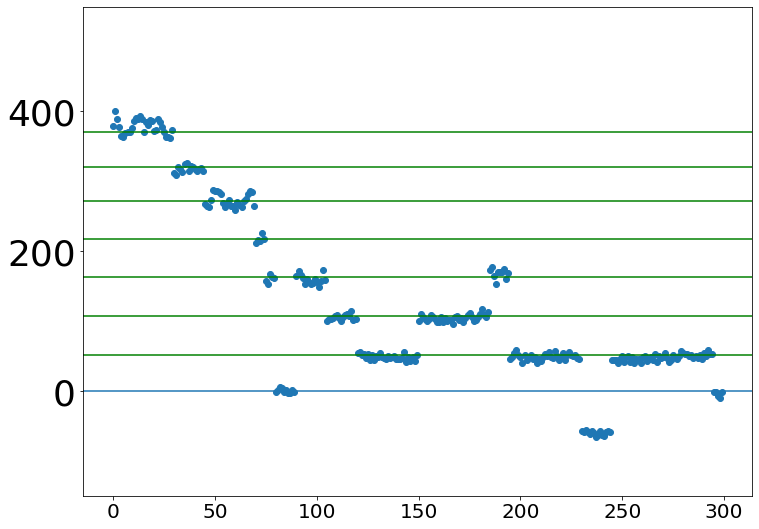

In [1554]:
# plot the in-phase response
plt.plot(range(len(indices)),in_phase,linestyle="",marker="o")
plt.ylim(-150,550)
plt.axhline(370,color="g")
plt.axhline(321,color="g")
plt.axhline(272,color="g")
plt.axhline(217,color="g")
plt.axhline(163,color="g")
plt.axhline(107,color="g")
plt.axhline(52,color="g")
plt.axhline(0)

plt.show()


In [1525]:
# load the response from the max_corr (basically)

resp_z = discharge_response(foldername=foldername,str_axis='z',drive_freq=71,max_file=1000)
resp_x = discharge_response(foldername=foldername,str_axis='x',drive_freq=71,max_file=1000)
resp_y = discharge_response(foldername=foldername,str_axis='y',drive_freq=71,max_file=1000)

295  files in folder
295  files loaded
295  files in folder
295  files loaded
295  files in folder
295  files loaded


In [1517]:
# sum up everything in bins of 5 measurements
bin_cont_z, bin_cont_x, bin_cont_y = [ [] for x in range(3)]
bin_unc_z, bin_unc_x, bin_unc_y = [ [] for x in range(3)]
bin_corr, bin_cont_corr, bin_cont_corr = [ [] for x in range(3)]
bin_unc_corr, bin_unc_corr, bin_unc_corr = [ [] for x in range(3)]

bin_size = 5

for i in np.arange(0,len(resp_z),bin_size):
    bin_cont_z.append(np.mean(resp_z[i:i+bin_size]))
    bin_unc_z.append(np.std(resp_z[i:i+bin_size]))
    bin_corr.append(np.mean(in_phase[i:i+bin_size]))
    bin_unc_corr.append(np.std(in_phase[i:i+bin_size]))  

    

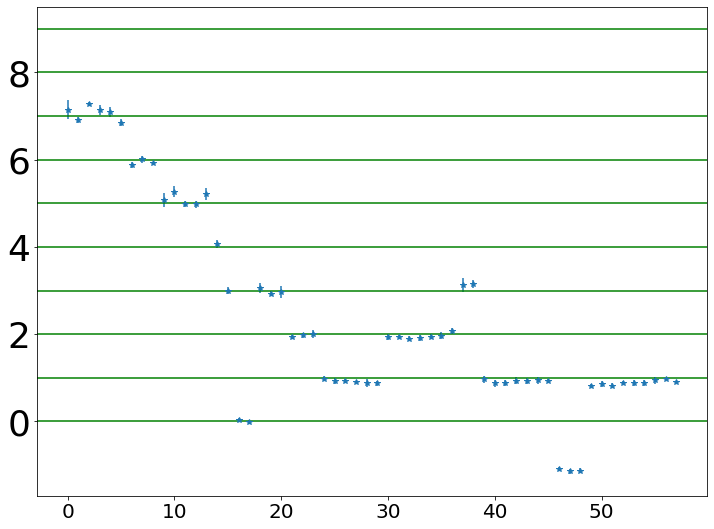

In [1518]:
# plot 5 bins with errors
plt.errorbar(range(len(bin_corr)),np.divide(bin_corr,53.5),np.divide(bin_unc_corr,55),linestyle="",marker="*")
#plt.errorbar(range(len(bin_cont_z)),np.divide(bin_cont_z,53),np.divide(bin_unc_z,55),linestyle="",marker="o")
#plt.xlim(50,)#
#plt.ylim(-0,8)
for i in range(10):
    plt.axhline(i,color="g")
